In [4]:
from optuna.integration.lightgbm import lgb
import pandas as pd
import numpy as np
import optuna
import pickle
import os
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import TimeSeriesSplit as tss
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from matplotlib import rcParams


rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Sans GB']


warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

# pandasの表示を設定
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 50

%matplotlib inline

In [5]:
start_date = '2023-7-1'
end_date = '2023-7-31'

In [6]:
df = pd.read_csv('train_merged.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
ignore_features_binary = ['end_code', 'start_code', 'KP', 'is_congestion', 'holiday', 'speed_change_hour_move_ave_7d']
ignore_features_reg = ['end_code', 'start_code', 'KP', 'is_congestion', 'holiday', 'search_specified_same_day_hour_mean', 'search_unspecified_same_day_mean', 'OCC_hour_move_ave_7d']
categorical_features = ['day_of_week', 'section', 'n_of_holidays']

# sample_weightに入れる重みを計算
coef_binary_0 = 10
coef_binary_1 = 1

weight_binary = compute_sample_weight(class_weight='balanced', y=df['is_congestion_tomorrow'])
weight_df = pd.DataFrame()
weight_df['is_congestion_tomorrow'] = df['is_congestion_tomorrow']
weight_df['weight_binary'] = weight_binary
weight_df.loc[weight_df['is_congestion_tomorrow'] == 0, 'weight_binary'] = (weight_df[weight_df['is_congestion_tomorrow'] == 0]['weight_binary'] * coef_binary_0).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 0].index)
weight_df.loc[weight_df['is_congestion_tomorrow'] == 1, 'weight_binary'] = (weight_df[weight_df['is_congestion_tomorrow'] == 1]['weight_binary'] * coef_binary_1).set_axis(weight_df.loc[weight_df['is_congestion_tomorrow'] == 1].index)
df['weight_binary'] = weight_df['weight_binary']

coef_reg_0 = 1
coef_reg_1 = 50

weight_reg = compute_sample_weight(class_weight='balanced', y=df['speed_tomorrow'])
weight_df = pd.DataFrame()
weight_df['speed_tomorrow'] = df['speed_tomorrow']
weight_df['weight_reg'] = weight_reg
weight_df.loc[weight_df['speed_tomorrow'] > 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] > 40]['weight_reg'] * coef_reg_0).set_axis(weight_df.loc[weight_df['speed_tomorrow'] > 40].index)
weight_df.loc[weight_df['speed_tomorrow'] <= 40, 'weight_reg'] = (weight_df[weight_df['speed_tomorrow'] <= 40]['weight_reg'] * coef_reg_1).set_axis(weight_df.loc[weight_df['speed_tomorrow'] <= 40].index)
df['weight_reg'] = weight_df['weight_reg']


#df_train = df.copy()
df_train = df[df['datetime'] < start_date+' 00:00:00']
#df_train = df_train[df_train['tomorrow_holiday'] == 1]
df_test = df[(df['datetime'] >= start_date+' 00:00:00') & (df['datetime'] <= end_date+' 23:00:00')]
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])

predictions = []

folds = tss(n_splits=5)

test_x_binary = df_test.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'tomorrow_holiday', 'weight_binary', 'weight_reg', *ignore_features_binary], axis=1)
test_y_binary = df_test['is_congestion_tomorrow']

test_x_reg = df_test.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'tomorrow_holiday', 'weight_binary', 'weight_reg', *ignore_features_reg], axis=1)
test_y_reg = df_test['speed_tomorrow']


In [7]:
def find_optimal_threshold(answer, prob_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_score = 0

    for threshold in thresholds:
        prediction = (prob_scores > threshold).astype(int)
        score = f1_score(answer, prediction)

        if score > best_score:
            best_score = score
            best_threshold = threshold

    return best_score, best_threshold

[LightGBM] [Info] Number of positive: 4106, number of negative: 927028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3779
[LightGBM] [Info] Number of data points in the train set: 931134, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110744 -> initscore=-2.083160
[LightGBM] [Info] Start training from score -2.083160
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	Train's binary_logloss: 0.0688881	Test's binary_logloss: 0.196788


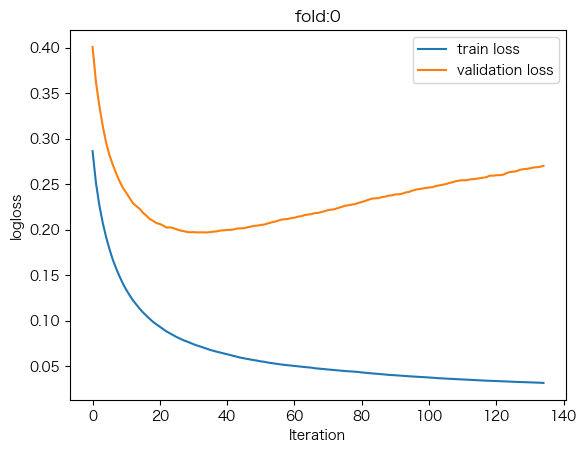

100%|██████████| 30/30 [00:00<00:00, 277.78it/s]


Fold 0:
TN  FP
FN  TP
[[203816   1240]
 [   483    340]]
Accuracy: 0.9916310065621069
Recall: 0.4131227217496962
Precision: 0.21518987341772153
F1 score : 0.28297960882230544
---------------------------------------------

[LightGBM] [Info] Number of positive: 10679, number of negative: 1851586
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3806
[LightGBM] [Info] Number of data points in the train set: 1862265, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139537 -> initscore=-1.819144
[LightGBM] [Info] Start training from score -1.819144
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[47]	Train's binary_logloss: 0.0909787	Test's binary_logloss: 0.112577


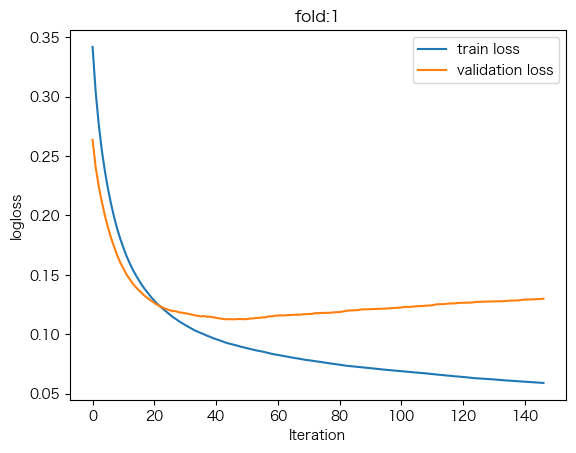

100%|██████████| 30/30 [00:00<00:00, 230.62it/s]


Fold 1:
TN  FP
FN  TP
[[204398    658]
 [   523    300]]
Accuracy: 0.9942636208646827
Recall: 0.3645200486026732
Precision: 0.31315240083507306
F1 score : 0.33688938798427853
---------------------------------------------

[LightGBM] [Info] Number of positive: 13570, number of negative: 2779826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3812
[LightGBM] [Info] Number of data points in the train set: 2793396, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120690 -> initscore=-1.985908
[LightGBM] [Info] Start training from score -1.985908
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	Train's binary_logloss: 0.0735952	Test's binary_logloss: 0.0767677


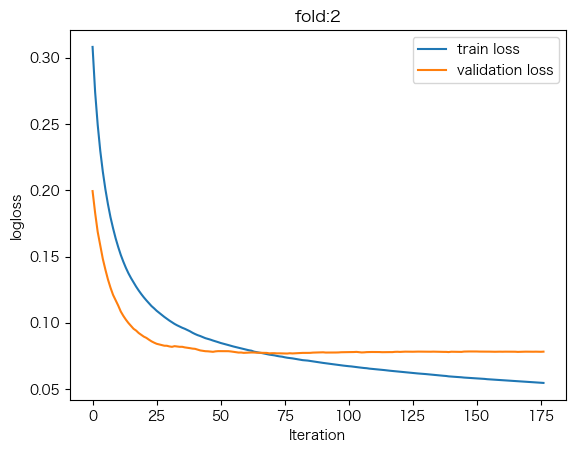

100%|██████████| 30/30 [00:00<00:00, 190.69it/s]


Fold 2:
TN  FP
FN  TP
[[204275    781]
 [   534    289]]
Accuracy: 0.9936127531219794
Recall: 0.3511543134872418
Precision: 0.27009345794392525
F1 score : 0.3053354463814052
---------------------------------------------

[LightGBM] [Info] Number of positive: 15238, number of negative: 3709289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055958 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3924
[LightGBM] [Info] Number of data points in the train set: 3724527, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.103546 -> initscore=-2.158429
[LightGBM] [Info] Start training from score -2.158429
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[46]	Train's binary_logloss: 0.0793155	Test's binary_logloss: 0.106977


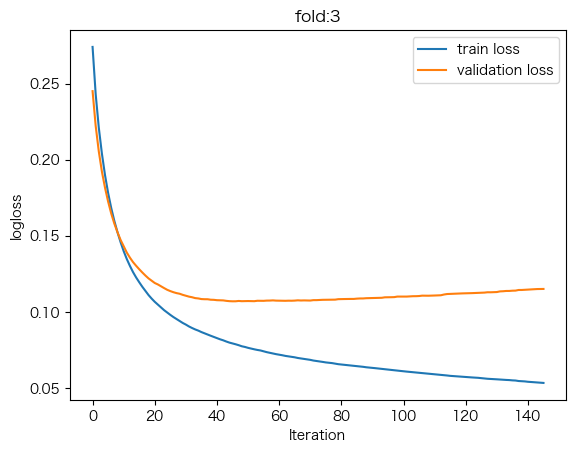

100%|██████████| 30/30 [00:00<00:00, 265.54it/s]


Fold 3:
TN  FP
FN  TP
[[204472    584]
 [   575    248]]
Accuracy: 0.994370479747813
Recall: 0.30133657351154314
Precision: 0.2980769230769231
F1 score : 0.2996978851963746
---------------------------------------------

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 18200, number of negative: 4637458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3950
[LightGBM] [Info] Number of data points in the train set: 4655658, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.099381 -> initscore=-2.204126
[LightGBM] [Info] Start training from sco

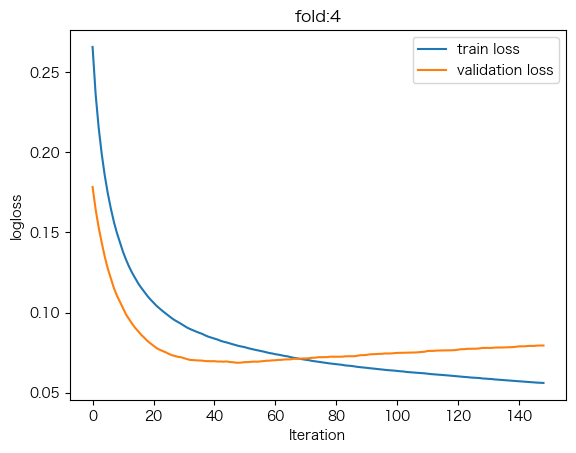

100%|██████████| 30/30 [00:00<00:00, 276.29it/s]


Fold 4:
TN  FP
FN  TP
[[204569    487]
 [   559    264]]
Accuracy: 0.9949193458293464
Recall: 0.32077764277035237
Precision: 0.35153129161118507
F1 score : 0.3354510800508259
---------------------------------------------



In [8]:
lgb_models_binary = []
best_thresholds = []

params = {
        'boosting_type': 'gbdt',      # GBDTを指定
        'objective': 'binary',    # 回帰を指定
        'metric': 'binary_logloss',             # 回帰の損失（誤差）
        'seed': 123                   # シード値
        }


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train['is_congestion_tomorrow']
    train_x = train.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_binary], axis=1)
    val_y = val['is_congestion_tomorrow']
    val_x = val.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_binary], axis=1)
    
    weight_train = train['weight_binary']
    weight_val = val['weight_binary']
    
    lgb_train = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_val = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(
                params,
                lgb_train,
                categorical_feature=categorical_features,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['Train', 'Test'],
                num_boost_round=100000,
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)] ) 
    
    best_params = model.params
    
    lgb_models_binary.append(model)
    
    loss_train = lgb_results['Train']['binary_logloss']
    loss_test = lgb_results['Test']['binary_logloss']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='validation loss')
    
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_binary.groupby(test_x_binary['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', 'is_congestion_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer = answer_df['is_congestion_tomorrow']
    prediction = answer_df['prediction']
    best_threshold = find_optimal_threshold(answer, prediction)[1]
    best_thresholds.append(best_threshold)
    best_predict = (prediction > best_threshold).astype(int)
    
    predictions.append(best_predict)
    
    accuracy = accuracy_score(answer, best_predict)
    recall = recall_score(answer, best_predict)
    precision = precision_score(answer, best_predict)
    f1 = f1_score(answer, best_predict)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer, best_predict))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 931134, number of used features: 16
[LightGBM] [Info] Start training from score 76.270662
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[38]	Train's rmse: 11.4437	Test's rmse: 18.7002


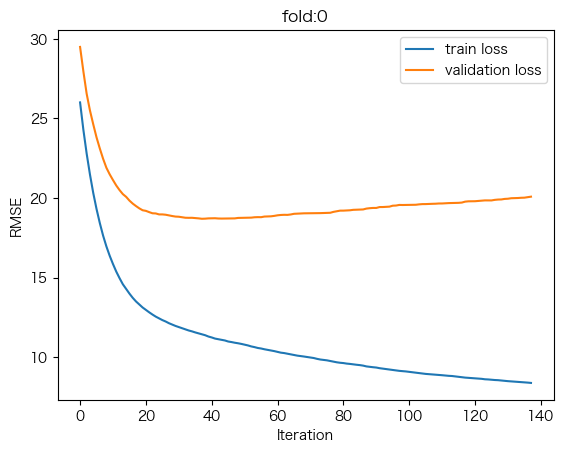

100%|██████████| 30/30 [00:00<00:00, 280.13it/s]


Fold 0:
TN  FP
FN  TP
[[204916    140]
 [   792     31]]
Accuracy: 0.9954730691328402
Recall: 0.03766707168894289
Precision: 0.18128654970760233
F1 score : 0.06237424547283702
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 1862265, number of used features: 16
[LightGBM] [Info] Start training from score 72.493658
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[88]	Train's rmse: 12.0203	Test's rmse: 15.5349


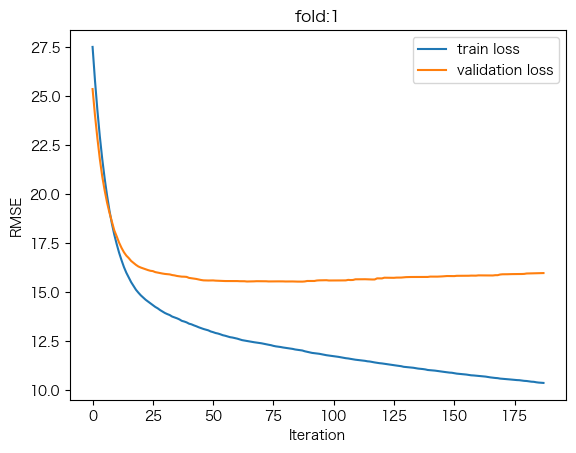

100%|██████████| 30/30 [00:00<00:00, 177.69it/s]


Fold 1:
TN  FP
FN  TP
[[203974   1082]
 [   569    254]]
Accuracy: 0.9919807265432609
Recall: 0.3086269744835966
Precision: 0.19011976047904192
F1 score : 0.23529411764705882
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037893 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3302
[LightGBM] [Info] Number of data points in the train set: 2793396, number of used features: 16
[LightGBM] [Info] Start training from score 74.485855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[44]	Train's rmse: 13.4195	Test's rmse: 14.4232


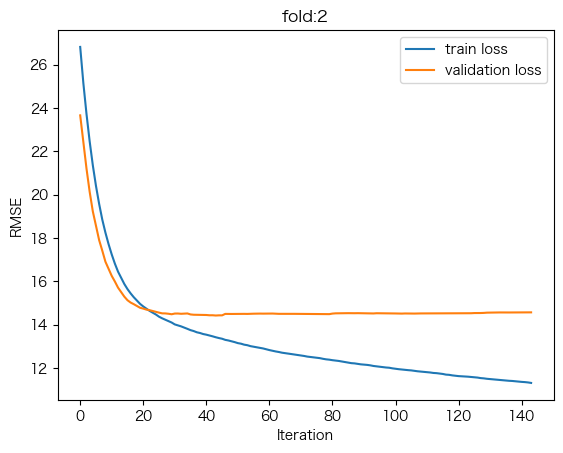

100%|██████████| 30/30 [00:00<00:00, 262.29it/s]


Fold 2:
TN  FP
FN  TP
[[203847   1209]
 [   572    251]]
Accuracy: 0.9913492876883995
Recall: 0.30498177399756987
Precision: 0.17191780821917807
F1 score : 0.219886114761279
---------------------------------------------

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 3724527, number of used features: 16
[LightGBM] [Info] Start training from score 76.697889
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	Train's rmse: 12.6512	Test's rmse: 15.6079


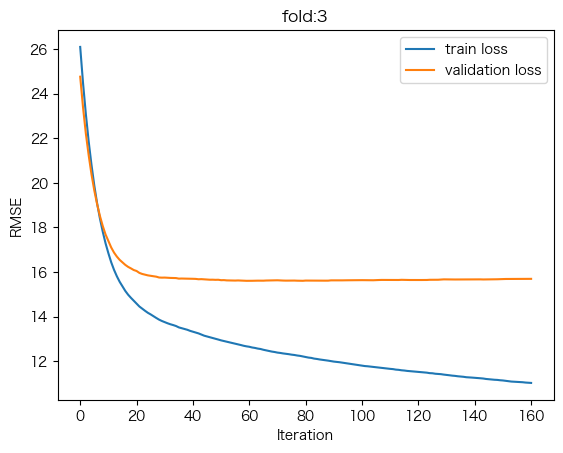

100%|██████████| 30/30 [00:00<00:00, 192.20it/s]


Fold 3:
TN  FP
FN  TP
[[203558   1498]
 [   564    259]]
Accuracy: 0.9899844083175069
Recall: 0.31470230862697446
Precision: 0.14741035856573706
F1 score : 0.20077519379844963
---------------------------------------------

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3440
[LightGBM] [Info] Number of data points in the train set: 4655658, number of used features: 16
[LightGBM] [Info] Start training from score 77.502178
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	Train's rmse: 12.5349	Test's rmse: 

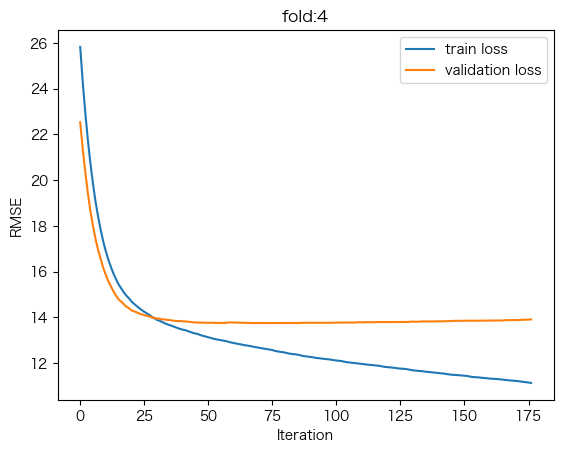

100%|██████████| 30/30 [00:00<00:00, 190.37it/s]


Fold 4:
TN  FP
FN  TP
[[203566   1490]
 [   546    277]]
Accuracy: 0.9901106960884791
Recall: 0.33657351154313486
Precision: 0.15676287492925864
F1 score : 0.2138996138996139
---------------------------------------------



In [9]:

lgb_models_reg = []

params = {
        'boosting_type': 'gbdt',      # GBDTを指定
        'objective': 'regression',    # 回帰を指定
        'metric': 'rmse',             # 回帰の損失（誤差）
        'seed': 123                   # シード値
        }


for fold, (train_index, val_index) in enumerate(folds.split(df_train)):
    
    train, val = df_train.iloc[train_index], df_train.iloc[val_index]
    train_y = train['speed_tomorrow']
    train_x = train.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_reg], axis=1)
    val_y = val['speed_tomorrow']
    val_x = val.drop(['is_congestion_tomorrow', 'speed_tomorrow', 'datetime', 'weight_binary', 'weight_reg', 'tomorrow_holiday', *ignore_features_reg], axis=1)
    
    weight_train = train['weight_reg']
    weight_val = val['weight_reg']
    
    lgb_train = lgb.Dataset(train_x, train_y, weight=weight_train)
    lgb_val = lgb.Dataset(val_x, val_y, weight=weight_val)
    
    verbose_eval = -1
    lgb_results = {}
    
    model = lgb.train(
                params,
                lgb_train,
                categorical_feature=categorical_features,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['Train', 'Test'],
                num_boost_round=100000,
                callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(verbose_eval), lgb.record_evaluation(lgb_results)] ) 
    
    best_params = model.params
    
    lgb_models_reg.append(model)
    
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    
    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='validation loss')
    
    plt.legend()
    plt.show()
    
    pred_df = pd.DataFrame(columns=['datetime', 'section', 'prediction'])
    for d, input_df in tqdm(test_x_reg.groupby(test_x_reg['datetime'].dt.date)):
        input = input_df.drop('datetime', axis=1).reset_index(drop=True)
        pred = model.predict(input, num_iteration=model.best_iteration)
        preds = input_df[['datetime', 'section']].copy()
        preds['prediction'] = pred
        pred_df = pred_df.append(preds, ignore_index=True)    

    answer_df = df_test[['datetime', 'section', 'speed_tomorrow']]
    pred_df['datetime'] = pd.to_datetime(pred_df['datetime'])
    pred_df = pred_df.reset_index(drop=True)
    answer_df = pd.merge(answer_df, pred_df, on=['datetime', 'section'], how='inner')
    answer_binary = (answer_df['speed_tomorrow'] <= 40).astype(int)
    prediction_binary = (answer_df['prediction'] <= 40).astype(int)
    
    predictions.append(prediction_binary)
    
    accuracy = accuracy_score(answer_binary, prediction_binary)
    recall = recall_score(answer_binary, prediction_binary)
    precision = precision_score(answer_binary, prediction_binary)
    f1 = f1_score(answer_binary, prediction_binary)

    print(f'Fold {fold}:')
    print('TN  FP\nFN  TP')
    print(confusion_matrix(answer_binary, prediction_binary))
    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    print(f'Precision: {precision}')
    print(f'F1 score : {f1}')
    print('---------------------------------------------\n')

In [10]:
majority_predictions = []

for i in range(len(predictions[0])):
    preds = [pred[i] for pred in predictions]
    mode = Counter(preds).most_common(1)[0][0]
    majority_predictions.append(mode)

In [11]:
sub_df = df_test[['datetime', 'start_code', 'end_code', 'KP']]
sub_df['datetime'] = pd.to_datetime(sub_df['datetime'])
sub_df['prediction'] = majority_predictions
sub_df['datetime'] += pd.to_timedelta(1, 'd')
answer_df = pd.merge(sub_df, df_test[['datetime', 'start_code', 'end_code', 'KP', 'holiday', 'is_congestion']], on=['datetime', 'start_code', 'end_code', 'KP'], how='inner')
answer_holiday_df = answer_df.loc[(answer_df['holiday'] == 1)]
answer = answer_df['is_congestion']
answer_holiday = answer_holiday_df['is_congestion']
prediction = answer_df['prediction']
prediction_holiday =answer_holiday_df['prediction']

accuracy = accuracy_score(answer, prediction)
recall = recall_score(answer, prediction)
precision = precision_score(answer, prediction)
f1 = f1_score(answer, prediction)

accuracy_holiday = accuracy_score(answer_holiday, prediction_holiday)
recall_holiday = recall_score(answer_holiday, prediction_holiday)
precision_holiday = precision_score(answer_holiday, prediction_holiday)
f1_holiday = f1_score(answer_holiday, prediction_holiday)

print('Voting:\n')
print('All days')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer, prediction))
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 score : {f1}')
print('\n')
print('Only holiday')
print('TN  FP\nFN  TP')
print(confusion_matrix(answer_holiday, prediction_holiday))
print(f'Accuracy: {accuracy_holiday}')
print(f'Recall: {recall_holiday}')
print(f'Precision: {precision_holiday}')
print(f'F1 score : {f1_holiday}')

Voting:

All days
TN  FP
FN  TP
[[197669    529]
 [   523    258]]
Accuracy: 0.9947130099156193
Recall: 0.33034571062740076
Precision: 0.3278271918678526
F1 score : 0.3290816326530612


Only holiday
TN  FP
FN  TP
[[61166   156]
 [  311   117]]
Accuracy: 0.9924372469635627
Recall: 0.2733644859813084
Precision: 0.42857142857142855
F1 score : 0.3338088445078459


In [12]:
best_thresholds

[0.4545454545454546,
 0.7272727272727273,
 0.7070707070707072,
 0.787878787878788,
 0.787878787878788]

In [13]:
model_names = {
    0: "model_binary_fold_0",
    1: "model_binary_fold_1",
    2: "model_binary_fold_2",
    3: "model_binary_fold_3",
    4: "model_binary_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models_binary):
    model_name = model_names.get(fold, f'model_binary_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)
        

model_names = {
    0: "model_reg_fold_0",
    1: "model_reg_fold_1",
    2: "model_reg_fold_2",
    3: "model_reg_fold_3",
    4: "model_reg_fold_4",}

save_dir = "models/"
os.makedirs(save_dir, exist_ok=True)

for fold, model in enumerate(lgb_models_reg):
    model_name = model_names.get(fold, f'model_reg_fold_{fold}')
    with open(os.path.join(save_dir, f'{model_name}.pkl'), 'wb') as f:
        pickle.dump(model, f)

In [14]:
road_df= pd.read_csv('./given_files/road_local.csv')
answer_df['block'] = answer_df['start_code'].astype(str) + '_' + answer_df['end_code'].astype(str)
road_df['block'] = road_df['start_code'].astype(str) + '_' + road_df['end_code'].astype(str)
road_df = road_df[['block', 'direction', 'start_lat', 'end_lat', 'start_lng', 'end_lng']]
road_df['direction'] = road_df['direction'].replace({'上り': 1, '下り': 0})

answer_df = answer_df.merge(road_df, on=['block'], how='left')

answer_df['date'] = answer_df['datetime'].dt.date
answer_df['is_congestion_date_count'] = answer_df.groupby(['date'])['is_congestion'].transform('sum')
answer_df['prediction_date_count'] = answer_df.groupby(['date'])['prediction'].transform('sum')

answer_df['is_congestion_block_count'] =answer_df.groupby(['block', 'direction'])['is_congestion'].transform('sum')
answer_df['prediction_block_count'] =answer_df.groupby(['block', 'direction'])['prediction'].transform('sum')

In [15]:
answer_date_df = answer_df[['date', 'is_congestion_date_count', 'prediction_date_count']].drop_duplicates()

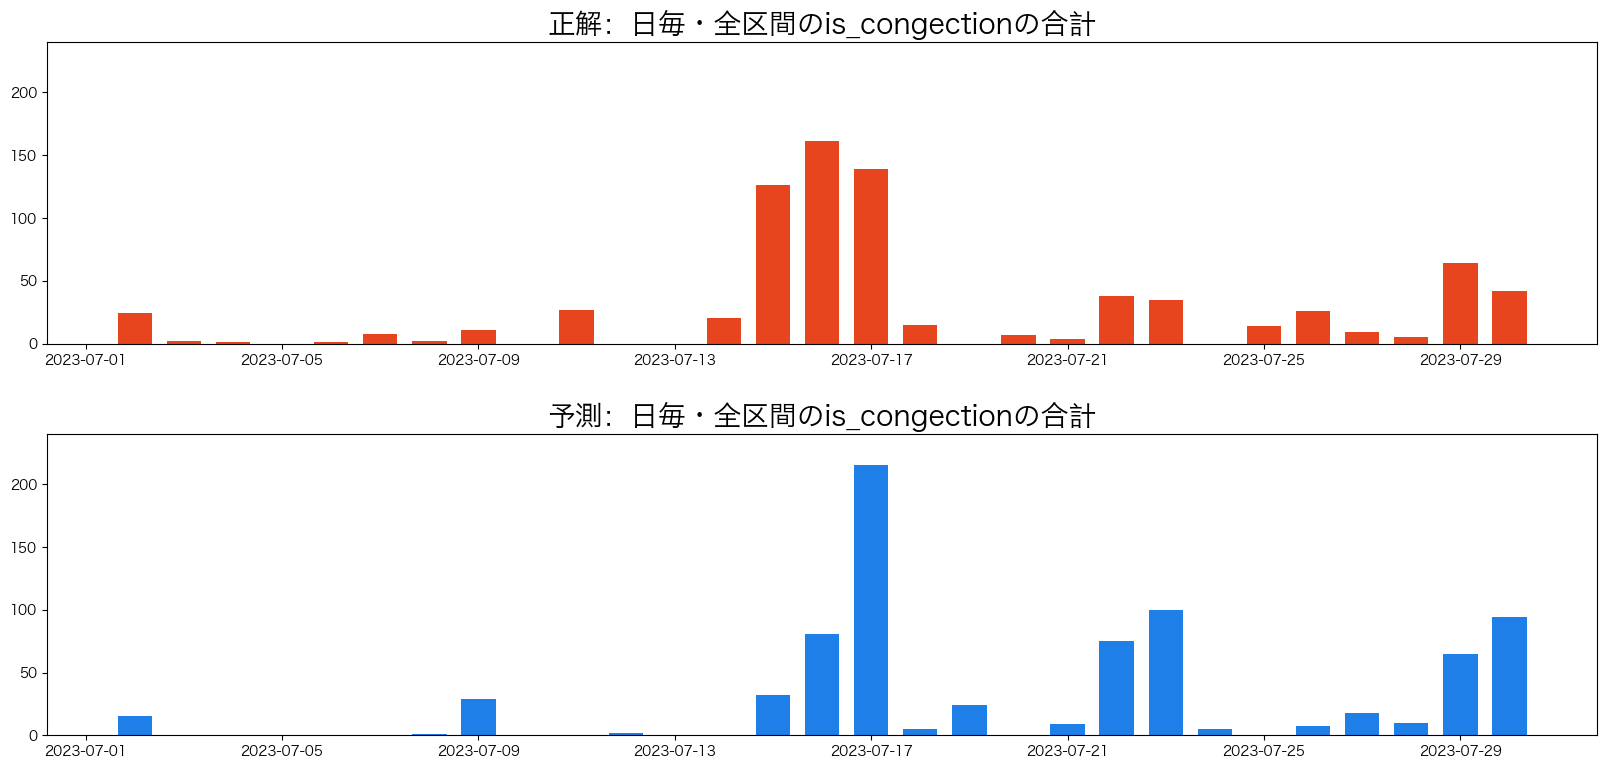

In [49]:
fig = plt.figure(figsize=(20,9))

plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(211, ylim=(0, 240))
ax2 = fig.add_subplot(212, ylim=(0, 240))

ax1.set_title('正解：日毎・全区間のis_congectionの合計', fontsize=20)
ax2.set_title('予測：日毎・全区間のis_congectionの合計', fontsize=20)

ax1.bar(answer_date_df['date'], answer_date_df['is_congestion_date_count'], width=0.7, fc='#E7451D')
ax2.bar(answer_date_df['date'], answer_date_df['prediction_date_count'], width=0.7, fc='#1D7FE7')

plt.savefig('./pictures/prediction_date_count.png')


In [17]:
answer_block_df = answer_df[['block', 'direction', 'start_lng', 'end_lng', 'start_lat', 'end_lat', 'is_congestion_block_count', 'prediction_block_count']].drop_duplicates()

answer_block_df_1 = answer_block_df[answer_df['direction'] == 1]
answer_block_df_0 = answer_block_df[answer_df['direction'] == 0]

congestion_series_1 = answer_block_df_1['is_congestion_block_count'].quantile([0.95, 0.9, 0.8, 0.7])
congestion_series_0 = answer_block_df_0['is_congestion_block_count'].quantile([0.95, 0.9, 0.8, 0.7])
prediction_series_1 = answer_block_df_1['prediction_block_count'].quantile([0.95, 0.9, 0.8, 0.7])
prediction_series_0 = answer_block_df_0['prediction_block_count'].quantile([0.95, 0.9, 0.8, 0.7])

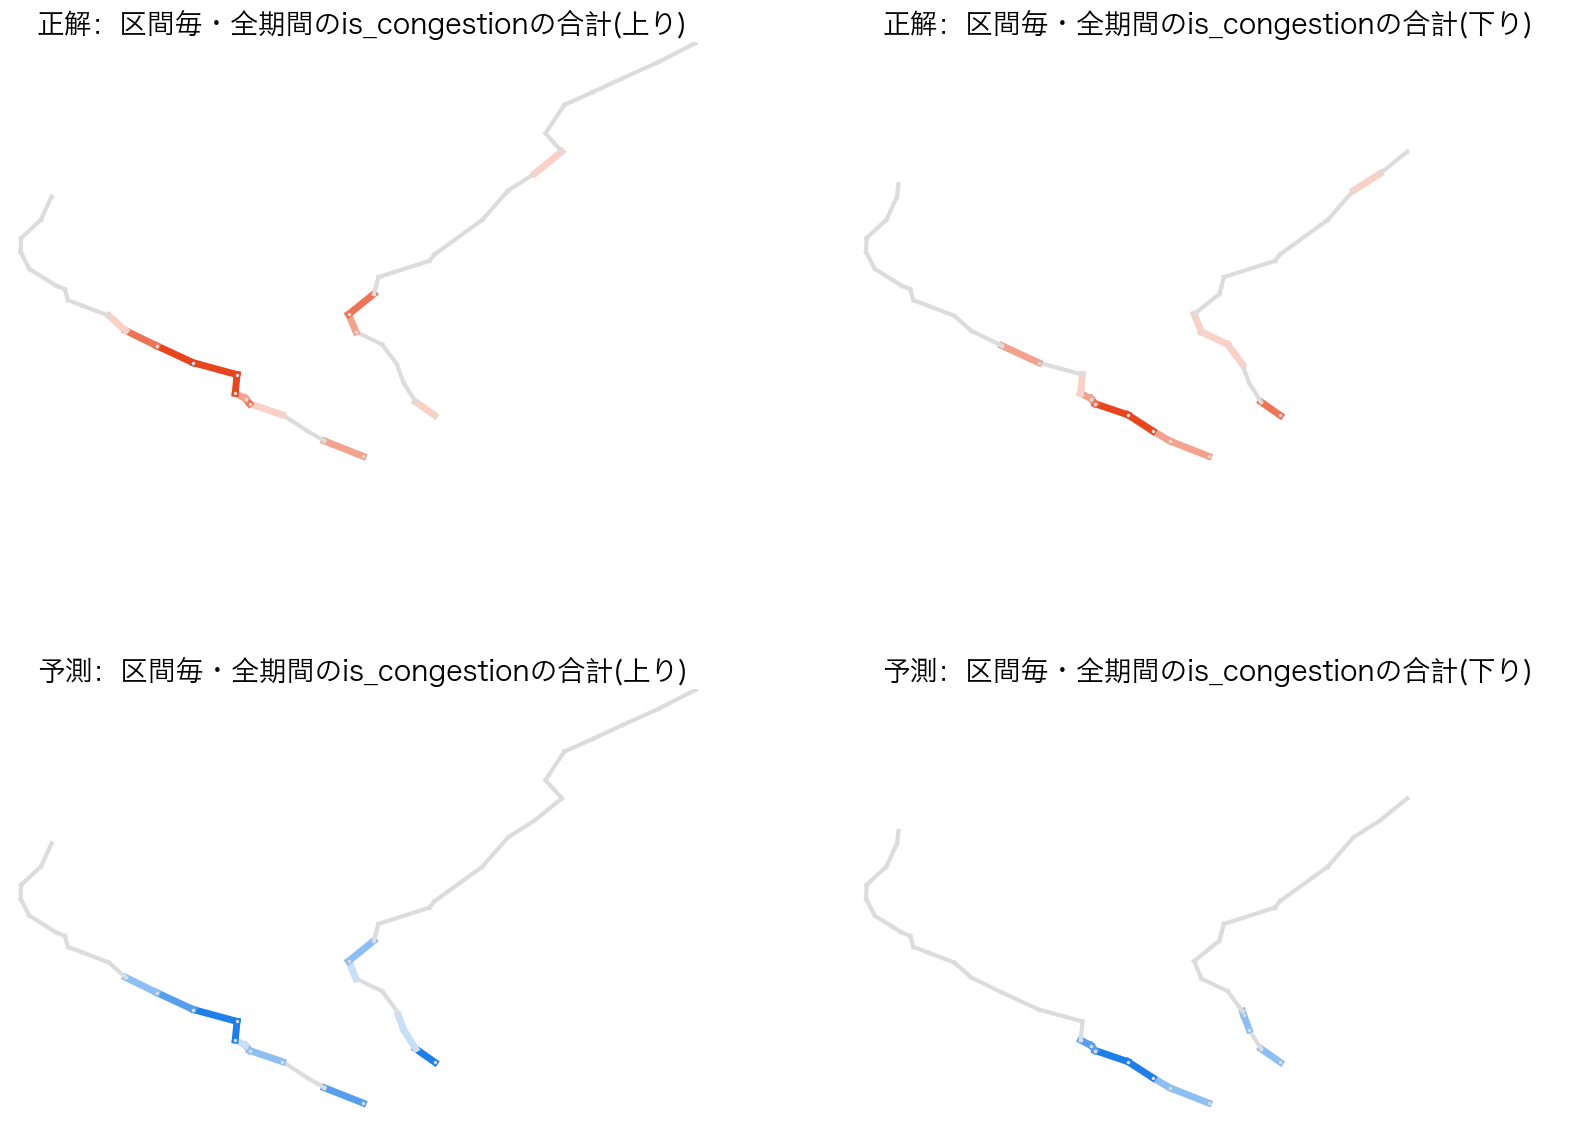

In [51]:
fig = plt.figure(figsize=(20,14))

plt.subplots_adjust(hspace=0.5)

ax1 = fig.add_subplot(221, title='Answer(上り)', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax2 = fig.add_subplot(222, title='Prediction(上り)', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax3 = fig.add_subplot(223, title='Answer(下り)', ylim=(35.7, 37.12), xlim=(139, 140.2))
ax4 = fig.add_subplot(224, title='Prediction(下り)', ylim=(35.7, 37.12), xlim=(139, 140.2))

ax1.set_title('正解：区間毎・全期間のis_congestionの合計(上り)', fontsize=20)
ax2.set_title('正解：区間毎・全期間のis_congestionの合計(下り)', fontsize=20)
ax3.set_title('予測：区間毎・全期間のis_congestionの合計(上り)', fontsize=20)
ax4.set_title('予測：区間毎・全期間のis_congestionの合計(下り)', fontsize=20)

for index,row in answer_block_df_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    congestion = row['is_congestion_block_count']
    
    colorlist=['#E7451D', '#ED7456', '#F3A28E', '#F9D1C7', 'gainsboro']

    if congestion >= congestion_series_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (congestion >= congestion_series_1[0.9]) & (congestion < congestion_series_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (congestion >= congestion_series_1[0.8]) & (congestion < congestion_series_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (congestion >= congestion_series_1[0.7]) & (congestion < congestion_series_1[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax1.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax1.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax1.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax1.axis('off')

for index,row in answer_block_df_1.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    prediction = row['prediction_block_count']
    
    colorlist=['#1D7FE7', '#569FED', '#8EBFF3', '#C7DFF9', 'gainsboro']

    if prediction >= prediction_series_1[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (prediction >= prediction_series_1[0.9]) & (prediction < prediction_series_1[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (prediction >= prediction_series_1[0.8]) & (prediction < prediction_series_1[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (prediction >= prediction_series_1[0.7]) & (prediction < prediction_series_1[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax3.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax3.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax3.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3) 
    ax3.axis('off')

for index,row in answer_block_df_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    congestion = row['is_congestion_block_count']
    
    colorlist=['#E7451D', '#ED7456', '#F3A28E', '#F9D1C7', 'gainsboro']

    if congestion >= congestion_series_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (congestion >= congestion_series_0[0.9]) & (congestion < congestion_series_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (congestion >= congestion_series_0[0.8]) & (congestion < congestion_series_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (congestion >= congestion_series_0[0.7]) & (congestion < congestion_series_0[0.8]):
        color = colorlist[3]
        linewidth = 5        
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax2.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax2.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax2.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3)
    ax2.axis('off')

for index,row in answer_block_df_0.iterrows():
    
    start_lng = row['start_lng']
    end_lng = row['end_lng']
    start_lat = row['start_lat']
    end_lat = row['end_lat']
    prediction = row['prediction_block_count']
    
    colorlist=['#1D7FE7', '#569FED', '#8EBFF3', '#C7DFF9', 'gainsboro']

    if prediction >= prediction_series_0[0.95]:
        color = colorlist[0]
        linewidth = 5
    elif (prediction >= prediction_series_0[0.9]) & (prediction < prediction_series_0[0.95]):
        color = colorlist[1]
        linewidth = 5
    elif (prediction >= prediction_series_0[0.8]) & (prediction < prediction_series_0[0.9]):
        color = colorlist[2]
        linewidth = 5
    elif (prediction >= prediction_series_0[0.7]) & (prediction < prediction_series_0[0.8]):
        color = colorlist[4]
        linewidth = 3 
    else:
        color = colorlist[4]
        linewidth = 3
        
    ax4.plot([start_lng, end_lng], [start_lat, end_lat], color=color, linestyle='-', linewidth=linewidth)
    ax4.plot(start_lng, start_lat, marker='.', c='gainsboro', markersize=3) 
    ax4.plot(end_lng, end_lat, marker='.', c='gainsboro',markersize=3) 
    ax4.axis('off')
    
plt.savefig('./pictures/prediction_map.png')
